In [2]:
# PROCESS THE YOUNG STARS CATAOLOG:
# https://cdsarc.cds.unistra.fr/viz-bin/cat/J/A+A/620/A172
#
#
# ZACK REEVES
# CREATED: 2023
#
# VERSIONS:
#  1.1  OCT 2023 CREATE JUPYTER NOTEBOOK

In [3]:
import pandas as pd
import numpy as np
import sys
import collections

from astropy.io import ascii
import astropy.units as u
import astropy.coordinates
from astropy.coordinates import Angle
from astropy.table import unique, vstack, Table, join

from astroquery.vizier import Vizier

sys.path.insert(0, '..')
from common import file_functions, calculations, get_bailer_jones, gaia_functions

from matplotlib import pyplot as plt, colors

In [4]:
# Define the metadata for the data set.  NEED TO EDIT
#https://www.aanda.org/articles/aa/full_html/2023/06/aa43964-22/aa43964-22.html
metadata = {}

metadata['project'] = 'Digital Universe Atlas Gaia Subsets'
metadata['sub_project'] = 'Young Stars'

metadata['catalog'] = '3D mapping of young stars in the solar neighbourhood with Gaia DR2 (Zari+, 2023)'  #need to edit
metadata['catalog_author'] = 'Zari+'
metadata['catalog_year'] = '2023'
metadata['catalog_doi'] = 'doi:10.1051/0004-6361/202039498' #need to fix
metadata['catalog_bibcode'] = '2021A&A...649A...6G' #need to fix

metadata['prepared_by'] = 'Brian Abbott, Zack Reeves'
metadata['version'] = '1.1'

metadata['dir'] = metadata['sub_project'].replace(' ', '_').lower()
metadata['raw_data_dir'] = ''

metadata['data_group_title'] = 'Young'
metadata['data_group_desc'] = 'Young Stars'
metadata['data_group_desc_long'] = 'Young Stars in the Milky Way mapped by Gaia'
metadata['fileroot'] = 'young_stars'

file_functions.generate_asset_file(metadata)
file_functions.generate_license_file(metadata)

In [5]:
#Reading in the catalog with Vizier
#We specify the row limit to make sure we get all the stars in the catalog
#We place constraints on the Parallax as a preliminary thresh
#We specify columns = ['**'] to get all of the columns, not just the default ones
catalog = Vizier(catalog='J/A+A/620/A172', columns=['**'], row_limit=-1).query_constraints(Plx='> 0.0')

In [6]:
#This catalog comes with 4 tables:
# - Pre main sequence (has SIMBAD column)
# - Upper main sequence (has SIMBAD column)
# - Pre main sequence S=2 tangential velocity
# - Pre main sequence S=3 tangential velocity

#We first label each object with the table it came from
catalog[0]['table'] = catalog[0].Column(data=['Pre-main sequence']*len(catalog[0]),
                                        meta = collections.OrderedDict([('ucd', 'meta.table')]),
                                        description='Catalog Table')

catalog[1]['table'] = catalog[1].Column(data=['Upper main sequence']*len(catalog[1]),
                                        meta = collections.OrderedDict([('ucd', 'meta.table')]),
                                        description='Catalog Table')

catalog[2]['table'] = catalog[2].Column(data=['Pre-main sequence S=2']*len(catalog[2]),
                                        meta = collections.OrderedDict([('ucd', 'meta.table')]),
                                        description='Catalog Table')

catalog[3]['table'] = catalog[3].Column(data=['Pre-main sequence S=3']*len(catalog[3]),
                                        meta = collections.OrderedDict([('ucd', 'meta.table')]),
                                        description='Catalog Table')


#We concatenate these tables into one for a full catalog
#Some stars exist in multiple tables and present as duplicate objects
#We remove duplicate objects using the unique function
data = unique(vstack([catalog[0], catalog[1], catalog[2], catalog[3]], 
              metadata_conflicts='silent'), keys='Source', keep='first')

In [7]:
data

recno,Source,GLON,GLAT,Plx,e_Plx,pmGLON,e_pmGLON,pmGLAT,e_pmGLAT,pmlbcorr,RV,e_RV,Gmag,BPmag,RPmag,E_BR_RP_,chi2AL,NgAL,AG,E_BP-RP_,UWE,Simbad,_RA.icrs,_DE.icrs,table
,,deg,deg,mag,mag,mas / yr,mas / yr,mas / yr,mas / yr,,km / s,km / s,mag,mag,mag,,,,mag,mag,,,deg,deg,
int32,int64,float64,float64,float64,float32,float64,float32,float64,float32,float32,float64,float32,float64,float64,float64,float64,float64,int16,float32,float32,float32,str6,float64,float64,str21
78256,915553884118144,175.08323524451,-47.08903941868,2.1634,0.0734,-0.639,0.116,-6.936,0.116,0.0000,--,--,9.07101,9.12869,8.99339,1.15283,487.73,115,0.6006,0.3019,--,Simbad,45.40817337014,2.16826997394,Upper main sequence
79083,1195551392247936,173.61179863296,-48.25887009822,6.1016,0.1752,12.503,0.192,-4.343,0.194,0.0000,--,--,6.57496,6.58252,6.62812,1.13375,764.03,120,0.3309,0.1706,--,Simbad,43.88155084926,2.01821675745,Upper main sequence
77712,1402912413121792,173.24716308805,-47.28239584380,2.0920,0.1177,15.205,0.145,-5.333,0.146,0.0000,--,--,10.36702,10.42734,10.21292,1.18454,657.79,103,0.2829,0.1369,--,Simbad,44.37518745590,2.89590163789,Upper main sequence
77714,1546703623466880,171.67621197870,-48.22301132547,2.8533,0.0463,0.033,0.084,2.348,0.084,0.0000,--,--,10.03341,10.22926,9.74427,1.16817,352.2,119,0.6511,0.3200,--,Simbad,42.95930603592,2.92045698074,Upper main sequence
6592,1939920764151808,173.72413813809,-45.85198831324,8.9190,0.0799,7.783,0.149,-4.880,0.148,0.1680,--,--,14.35860,15.91036,13.13935,1.48514,785.87,129,0.2365,0.1311,2.5175,Simbad,45.59978350959,3.70765186755,Pre-main sequence
76614,2015099871749760,173.17076762967,-46.47763857888,3.3820,0.0579,5.135,0.095,-2.605,0.095,0.0000,--,--,8.68511,8.82983,8.48334,1.15470,417.61,128,0.4080,0.2112,--,Simbad,44.88972814394,3.51754443653,Upper main sequence
76617,2058736739430272,172.01741960546,-47.25019918480,11.5396,0.0779,30.559,0.188,10.503,0.191,0.0000,--,--,6.83826,7.00734,6.59841,1.15877,412.67,115,0.2558,0.1399,--,Simbad,43.78416203685,3.48681352980,Upper main sequence
42696,2151508033360512,173.09229505935,-45.83072638291,2.2418,0.1239,3.453,0.232,0.079,0.231,0.1644,--,--,17.02869,18.47479,15.83597,1.47147,341.35,151,0.4778,0.2324,1.5291,Simbad,45.29430901433,4.02594774947,Pre-main sequence


In [8]:
#querying Gaia for bailer-jones distances
distances = get_bailer_jones.get_bj_distances(data, source_id='Source')
distances

INFO: Login to gaia TAP server [astroquery.gaia.core]
OK
INFO: Login to gaia data server [astroquery.gaia.core]
OK
Sending pytable.
Uploaded table 'gaia_ids'.
INFO: Query finished. [astroquery.utils.tap.core]
Table 'gaia_ids' deleted.
Removed jobs: '1761598750009O'.
INFO: Gaia TAP server logout OK [astroquery.gaia.core]
INFO: Gaia data server logout OK [astroquery.gaia.core]


Source,parallax,parallax_error,r_med_geo,r_hi_geo,r_lo_geo,r_med_photogeo,r_hi_photogeo,r_lo_photogeo,bj_distance,dcalc,e_bj_dist,bj_error_over_distance
,mas,mas,pc,pc,pc,pc,pc,pc,pc,,pc,
int64,float64,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64
915553884118144,2.41657315711544,0.06503937,406.31906,417.35565,396.11472,409.35403,420.52148,399.11896,406.31906,2,10.620468139648438,0.026138247381773966
1195551392247936,6.7012607524697705,0.0594965,148.4821,149.79608,147.0819,148.69157,150.24179,147.50731,148.4821,2,1.3570938110351562,0.00913978047097896
1402912413121792,1.8936555032255389,0.061270323,518.9543,537.28906,501.37936,517.29974,531.94476,499.68994,517.29974,1,16.127410888671875,0.031176143206269314
1546703623466880,2.9731512357879484,0.018662702,333.30548,335.44525,331.08746,333.03543,334.96265,330.85434,333.30548,2,2.17889404296875,0.0065372283609390945
1939920764151808,8.93541259252894,0.060772028,111.08601,112.14075,110.252,111.400505,112.143616,110.72438,111.08601,2,0.9443740844726562,0.008501286995718348
2015099871749760,3.3999269413063447,0.025680088,291.0515,293.18393,289.08463,291.3948,293.83084,288.98767,291.0515,2,2.049652099609375,0.00704223136911807
2058736739430272,11.645760038670751,0.026301257,85.561905,85.77035,85.34285,85.603134,85.80466,85.4444,85.561905,2,0.21374893188476562,0.002498178741070927
2151508033360512,2.2027587681506633,0.09944266,446.50943,466.66574,430.14502,447.3506,468.94974,431.3175,446.50943,2,18.260360717773438,0.040895800835760734


In [9]:
data = join(data, distances, keys='Source', join_type='inner')

     (source_id)).  Using Unique source identifier (unique within a single release)
     (source_id) for merged output [astropy.utils.metadata.merge]


In [10]:
gaia_functions.set_bj_distance(data)

In [11]:
# #fixing parallax units (Vizier labels it as a magnitude, probably meant milliarcseconds (mag versus mas))
# data['Plx'].unit=u.mas

In [12]:
# #thresh on parallax error (cutting on >10% error removes 1614 stars)
# data['parallax_over_error'] = [data['Plx'][i] / data['e_Plx'][i] for i in range(len(data))]
# data.remove_rows(np.where(data['parallax_over_error']<10)[0])

In [13]:
#calculating distance in light years and parsecs
#calculations.get_distance(data, parallax='Plx', use='parallax')

In [14]:
calculations.get_distance(data, dist='bj_distance', use='distance')

In [15]:
len(data)

122226

In [16]:
#threshing on distance
data.remove_rows(np.where(data['dist_pc']<0.10)[0])

In [17]:
data

recno,Source,GLON,GLAT,Plx,e_Plx,pmGLON,e_pmGLON,pmGLAT,e_pmGLAT,pmlbcorr,RV,e_RV,Gmag,BPmag,RPmag,E_BR_RP_,chi2AL,NgAL,AG,E_BP-RP_,UWE,Simbad,_RA.icrs,_DE.icrs,table,parallax,parallax_error,r_med_geo,r_hi_geo,r_lo_geo,r_med_photogeo,r_hi_photogeo,r_lo_photogeo,bj_distance,dcalc,e_bj_dist,bj_error_over_distance,dist_pc,dist_ly
,,deg,deg,mag,mag,mas / yr,mas / yr,mas / yr,mas / yr,,km / s,km / s,mag,mag,mag,,,,mag,mag,,,deg,deg,,mas,mas,pc,pc,pc,pc,pc,pc,pc,,pc,,pc,lyr
int32,int64,float64,float64,float64,float32,float64,float32,float64,float32,float32,float64,float32,float64,float64,float64,float64,float64,int16,float32,float32,float32,str6,float64,float64,str21,float64,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float32,float32
78256,915553884118144,175.08323524451,-47.08903941868,2.1634,0.0734,-0.639,0.116,-6.936,0.116,0.0000,--,--,9.07101,9.12869,8.99339,1.15283,487.73,115,0.6006,0.3019,--,Simbad,45.40817337014,2.16826997394,Upper main sequence,2.41657315711544,0.06503937,406.31906,417.35565,396.11472,409.35403,420.52148,399.11896,406.31906,2,10.620468139648438,0.026138247381773966,406.319061,1325.2
79083,1195551392247936,173.61179863296,-48.25887009822,6.1016,0.1752,12.503,0.192,-4.343,0.194,0.0000,--,--,6.57496,6.58252,6.62812,1.13375,764.03,120,0.3309,0.1706,--,Simbad,43.88155084926,2.01821675745,Upper main sequence,6.7012607524697705,0.0594965,148.4821,149.79608,147.0819,148.69157,150.24179,147.50731,148.4821,2,1.3570938110351562,0.00913978047097896,148.482101,484.3
77712,1402912413121792,173.24716308805,-47.28239584380,2.0920,0.1177,15.205,0.145,-5.333,0.146,0.0000,--,--,10.36702,10.42734,10.21292,1.18454,657.79,103,0.2829,0.1369,--,Simbad,44.37518745590,2.89590163789,Upper main sequence,1.8936555032255389,0.061270323,518.9543,537.28906,501.37936,517.29974,531.94476,499.68994,517.29974,1,16.127410888671875,0.031176143206269314,517.299744,1687.2
77714,1546703623466880,171.67621197870,-48.22301132547,2.8533,0.0463,0.033,0.084,2.348,0.084,0.0000,--,--,10.03341,10.22926,9.74427,1.16817,352.2,119,0.6511,0.3200,--,Simbad,42.95930603592,2.92045698074,Upper main sequence,2.9731512357879484,0.018662702,333.30548,335.44525,331.08746,333.03543,334.96265,330.85434,333.30548,2,2.17889404296875,0.0065372283609390945,333.305481,1087.1
6592,1939920764151808,173.72413813809,-45.85198831324,8.9190,0.0799,7.783,0.149,-4.880,0.148,0.1680,--,--,14.35860,15.91036,13.13935,1.48514,785.87,129,0.2365,0.1311,2.5175,Simbad,45.59978350959,3.70765186755,Pre-main sequence,8.93541259252894,0.060772028,111.08601,112.14075,110.252,111.400505,112.143616,110.72438,111.08601,2,0.9443740844726562,0.008501286995718348,111.086014,362.3
76614,2015099871749760,173.17076762967,-46.47763857888,3.3820,0.0579,5.135,0.095,-2.605,0.095,0.0000,--,--,8.68511,8.82983,8.48334,1.15470,417.61,128,0.4080,0.2112,--,Simbad,44.88972814394,3.51754443653,Upper main sequence,3.3999269413063447,0.025680088,291.0515,293.18393,289.08463,291.3948,293.83084,288.98767,291.0515,2,2.049652099609375,0.00704223136911807,291.051514,949.3
76617,2058736739430272,172.01741960546,-47.25019918480,11.5396,0.0779,30.559,0.188,10.503,0.191,0.0000,--,--,6.83826,7.00734,6.59841,1.15877,412.67,115,0.2558,0.1399,--,Simbad,43.78416203685,3.48681352980,Upper main sequence,11.645760038670751,0.026301257,85.561905,85.77035,85.34285,85.603134,85.80466,85.4444,85.561905,2,0.21374893188476562,0.002498178741070927,85.561905,279.1
42696,2151508033360512,173.09229505935,-45.83072638291,2.2418,0.1239,3.453,0.232,0.079,0.231,0.1644,--,--,17.02869,18.47479,15.83597,1.47147,341.35,151,0.4778,0.2324,1.5291,Simbad,45.29430901433,4.02594774947,Pre-main sequence,2.2027587681506633,0.09944266,446.50943,466.66574,430.14502,447.3506,468.94974,431.3175,446.50943,2,18.260360717773438,0.040895800835760734,446.509430,1456.3


In [18]:
#calculating cartesian coordinates
calculations.get_cartesian(data, glon='GLON', glat='GLAT', pmglon='pmGLON', pmglat='pmGLAT', 
                           radial_velocity='RV', frame='galactic')

In [19]:
gaia_functions.get_magnitudes(data, gmag='Gmag')
gaia_functions.get_luminosity(data)
data['bp_rp'] = [data['BPmag'][i] - data['RPmag'][i] for i in range(len(data))]
gaia_functions.get_bp_g_color(data, color='bp_rp')

<function matplotlib.pyplot.show(close=None, block=None)>

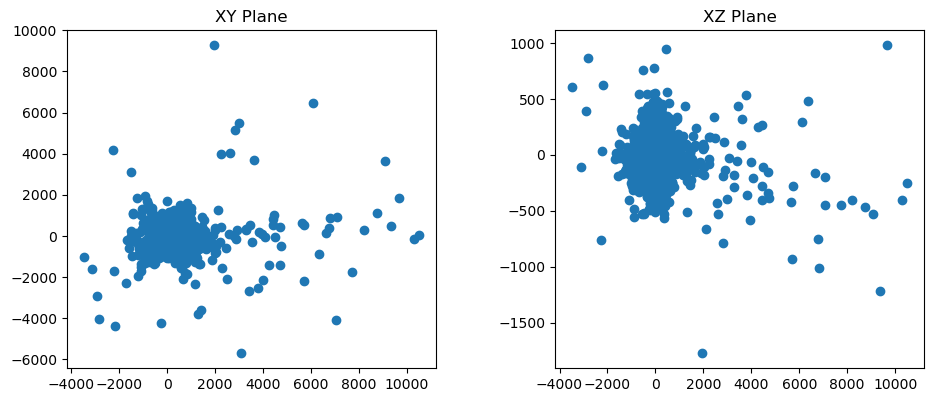

In [20]:
#2D Visualization
fig, ax = plt.subplots(1, 2)

#XY Plane
ax[0].scatter(data['x'], data['y'])
ax[0].set_title('XY Plane')

#XZ Plane
ax[1].scatter(data['x'], data['z'])
ax[1].set_title('XZ Plane')

#set good spacing
fig.tight_layout()
fig.set_size_inches(10, 4, forward=True)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

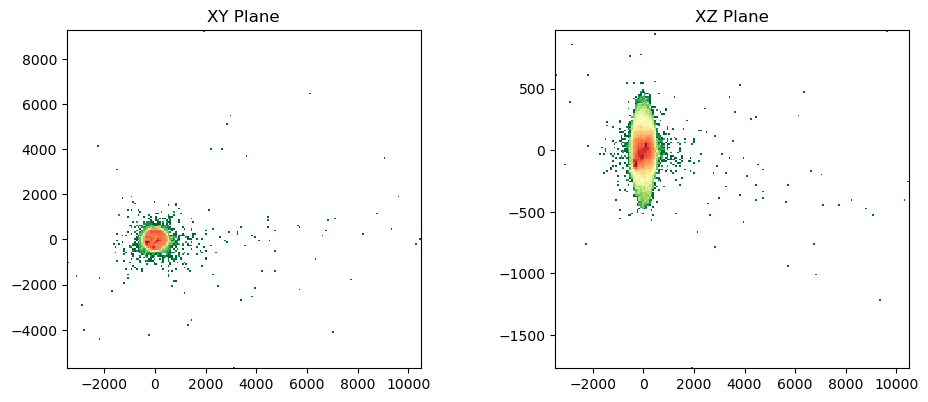

In [21]:
#2D Density Visualization
fig, ax = plt.subplots(1, 2)

#XY Plane
ax[0].hist2d(data['x'], data['y'], 
           bins = 200,  
           norm = colors.LogNorm(),  
           cmap = "RdYlGn_r",) 
ax[0].set_title('XY Plane')

#XZ Plane
ax[1].hist2d(data['x'], data['z'], 
           bins = 200,  
           norm = colors.LogNorm(),  
           cmap = "RdYlGn_r",) 
ax[1].set_title('XZ Plane')

#set good spacing
fig.tight_layout()
fig.set_size_inches(10, 4, forward=True)
plt.show

In [22]:
#setting texture number column
data['texnum'] = data.Column(data=[1]*len(data), 
                                  meta=collections.OrderedDict([('ucd', 'meta.texnum')]),
                                  description='Texture Number')

In [23]:
#construct a speck comment column
data['speck_label'] = data.Column(data=['#__'+str(name) for name in data['Source']], 
                                  meta=collections.OrderedDict([('ucd', 'meta.id')]),
                                 description='Gaia DR2 Source ID')

#construct a label column
data['label'] = ['GaiaDR2_'+ str(source) for source in data['Source']]  #leaving for now in case we want to add other labels

In [24]:
#construct a metadata table
columns = file_functions.get_metadata(data, columns=['x', 'y', 'z', 'color', 'lum', 'appmag', 'absmag', 'texnum', 'dist_ly', 'dcalc', 'u', 'v', 'w', 'speed', 'speck_label'])
columns

,name,unit,datatype,width,precision,arraysize,ucd,description
0,x,pc,float64,,6,,pos.cartesian.x,x position (galactic cartesian coordinates) in...
1,y,pc,float64,,6,,pos.cartesian.y,Position (y coordinate) in parsecs
2,z,pc,float64,,6,,pos.cartesian.z,Position (z coordinate) in parsecs
3,color,solLum,float64,,2,,phys.color,Gaia BP-G color
4,lum,solLum,float64,,6,,phys.luminosity,Stellar Luminosity
5,appmag,mag,float64,,6,,phot.mag;em.opt.G,Apparent magnitude in Gaia G-band
6,absmag,mag,float64,,6,,phot.magAbs;em.opt.G,Absolute magnitude in Gaia G-band
7,texnum,,int32,,,,meta.texnum,Texture Number
8,dist_ly,lyr,float32,,1,,pos.distance,Distance from Sun (lyr)
9,dcalc,,int32,,,,meta.dcalc,Distance Indicator: 1 indicates a Bailer-Jones...


In [25]:
# Print the speck file using the to_speck function in file_functions
file_functions.to_speck(metadata, Table.to_pandas(data), columns)

In [26]:
# Print the label file using the to_label function in file_functions
file_functions.to_label(metadata, Table.to_pandas(data))

In [27]:
# Print the csv file using the to_label function in file_functions
file_functions.to_csv(metadata, Table.to_pandas(data), columns)